<a href="https://colab.research.google.com/github/Yvnminc/COMP5329_A1/blob/main/COlip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clip (ViT and Transformer all included)

In [1]:
pip install -q openai-clip 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.9 MB/s eta 0:00:00


In [2]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#get the data from the drive
id = '1iIl3Yj4I2aowyVNj1NDWVclh3CSCgu76'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('multi-label-classification-competition-2023.zip')
#unzip the dataset
!unzip multi-label-classification-competition-2023.zip > /dev/null

In [3]:
import re
import pandas as pd
from io import StringIO

FILENAME = '/content/COMP5329S1A2Dataset/train.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    error_num = [4790,14716,14961,29895]
    for i in error_num:
      lines[i] = lines[i][:-3]+lines[i][-2:]
    df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
df

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.
...,...,...,...
29995,29995.jpg,8 1 2,A picture of a truck that is in the middle of ...
29996,29996.jpg,1,A plate topped with a pizza being cut with a s...
29997,29997.jpg,1,A man riding a snowboard on top of snow.
29998,29998.jpg,1,This photo shows people skiing in the mountains.


In [4]:
label_set = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]

In [5]:
df["Labels"].iloc[1]

single_label_list = [int(x) for x in df["Labels"].iloc[4].split()]
binary_vector = [1 if label in single_label_list else 0 for label in label_set]
binary_vector

[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Dataloader and augmentation

In [42]:
from torch.utils.data import Dataset, DataLoader
import re
import pandas as pd
import random
from io import StringIO
import torchvision.transforms as T
from torch.utils.data import random_split
import torch
import matplotlib.pyplot as plt
import os
import clip
from PIL import Image
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

FILENAME_TRAIN = '/content/COMP5329S1A2Dataset/train.csv'
FILENAME_TEST = '/content/COMP5329S1A2Dataset/test.csv'
DATA_PATH =  '/content/COMP5329S1A2Dataset/data'

class MmDataset(Dataset):
    def __init__(self,
                data_aug = True,
                indices= None,
                img_size = 336,
                iters = 1000,
                mode = "training"):
        
        df= read_path(mode)

        self.mode = mode
        self.image_filenames = df["ImageID"]
        self.captions = df["Caption"]

        if self.mode == "training":
            self.labels = df["Labels"]
        else:
          self.labels = df["Caption"].apply(lambda x: np.nan)

        self.data_aug = data_aug   
        self.indices = indices
        self.img_size = img_size
        self.iters = iters
        self.total_iters = iters
        self.all_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]

        # To initialise the dataset
        if indices is not None:
            self.image_filenames = [self.image_filenames[i] for i in indices]
            self.captions = [self.captions[i] for i in indices]
            self.labels = [self.labels[i] for i in indices]
        
        # #self.mean, self.std = self.compute_mean_std()
        
        self.transforms = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            # T.RandomRotation(degrees= (0, 45)),
            #T.RandomAutocontrast(),
            #T.RandomAdjustSharpness(sharpness_factor=3),
            #T.Pad(padding= random.randint(a = 0, b = int(self.img_size / 2))),
            T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
            #T.ElasticTransform(alpha=50.0),
            #T.RandomPosterize(bits=2),
            #T.RandomEqualize(),
            #T.TrivialAugmentWide(),
            T.ColorJitter(brightness=0.5,  # 亮度调整因子的范围，可以是浮点数或(min, max)元组
                          contrast=0.5,    # 对比度调整因子的范围，可以是浮点数或(min, max)元组
                          saturation=0.5,  # 饱和度调整因子的范围，可以是浮点数或(min, max)元组
                          hue=0.5           # 色相调整因子的范围，必须是浮点数，介于-0.5到0.5之间
                      )
        ])

        self.resize = T.Compose([
            T.Resize((self.img_size, self.img_size)),
            T.ToTensor(),
        ])

    def __getitem__(self, index):

        # Load images and labels
        image_path = os.path.join(DATA_PATH, self.image_filenames[index])
        prob = random.random()
        image = Image.open(image_path)

        if self.mode == "training":
          label_list = [int(x) for x in self.labels[index].split()]
          label = torch.from_numpy(np.array([1 if label in label_list else 0 for label in self.all_labels]).astype(np.float32)).unsqueeze(dim=0)
        else:
          label = self.labels[index]

        caption = self.captions[index]
             
        # arg_threshold = self.iters/self.total_iters
        # self.iters = self.iters -1

        # if self.data_aug and prob < arg_threshold:
        #     view2 = self.transforms(view2)

        view1 = self.resize(image)
        view2 = self.resize(image)

        return view1, view2, caption, label

    def __len__(self):
        return len(self.image_filenames)

def read_path(mode = "training"):
  
  if mode == "training":
    with open(FILENAME_TRAIN) as file:
      lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
      error_num = [4790,14716,14961,29895]
      for i in error_num:
        lines[i] = lines[i][:-3]+lines[i][-2:]
    
    return pd.read_csv(StringIO(''.join(lines)), escapechar="/")

  with open(FILENAME_TEST) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
  
  return pd.read_csv(StringIO(''.join(lines)), escapechar="/")


def get_loader(data_aug = None, bs = 8, img_size = 332, load_clip = False):
  # # Set the seed empirically
  # torch.manual_seed(3407)
  
  # 创建完整trainig和validation的数据集
  full_dataset = MmDataset(img_size= img_size)
  dataset_length = len(full_dataset)

  test_dataset = MmDataset(img_size= img_size, mode = "testing")

  # 计算训练、验证和测试集的长度
  train_length = int(0.9 * dataset_length)
  val_length = int(0.1 * dataset_length)

  # 使用 random_split 函数拆分数据集
  train_dataset, val_dataset = random_split(full_dataset, [train_length, val_length])

  # 使用相应的索引创建 MmDataset 实例
  train_dataset = MmDataset(img_size= img_size, data_aug= True, 
                            indices=train_dataset.indices)
  
  val_dataset = MmDataset(img_size= img_size, data_aug= False, 
                          indices=val_dataset.indices)

  # 现在您可以使用这些拆分数据集创建 DataLoader
  train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

  return train_loader, val_loader, test_loader


def imshow(img, title=None, cmap=None):
    # Convert from Tensor to NumPy array and transpose to (H, W, C)
    img = img.numpy().transpose((1, 2, 0))

    # Undo normalization if necessary
    if img.min() < 0 or img.max() > 1:
        img = img * 0.5 + 0.5

    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')

def plot_loder(dataloader):
    # Get a batch of data
    view1, view2, caption, label = next(iter(dataloader))
    # Display the first image and its corresponding label
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(view1[0], title='Original image')
    plt.subplot(1, 2, 2)
    imshow(view2[0], title='Augmented image')
    print(f"The caption is: {caption[0]}, the label is: {label[0]}")
    plt.show()


def print_shape(dataloader):
  view1, view2, caption, label = next(iter(dataloader))
  print(f"View1 is with shape: {view1.shape}, the type is {view1.dtype}.")
  print(f"View2 is with shape: {view2.shape}, the type is {view2.dtype}.")
  print(f"Label is with shape: {label.shape}, the type is {label.dtype}.")

In [43]:
train_loader, val_loader, test_loader = get_loader(bs = 512)

In [35]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

53
6
20


The caption is: A lone train engine approaches the traffic signals., the label is: tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])


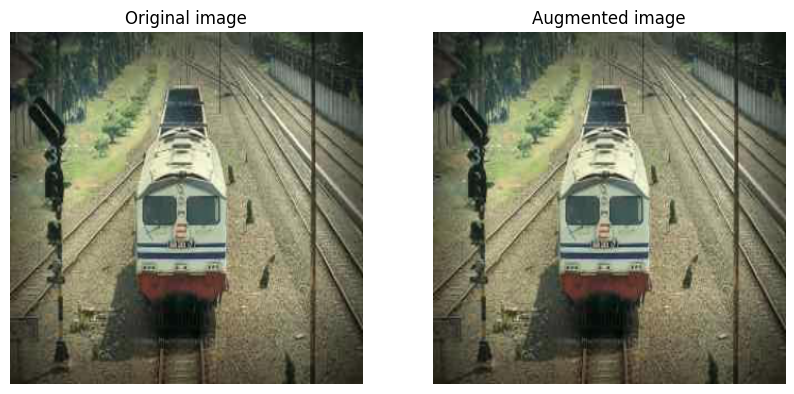

In [44]:
plot_loder(train_loader)

The caption is: A little girl waring a krispy kreme hat holding a box of krispy kreme donuts., the label is: nan


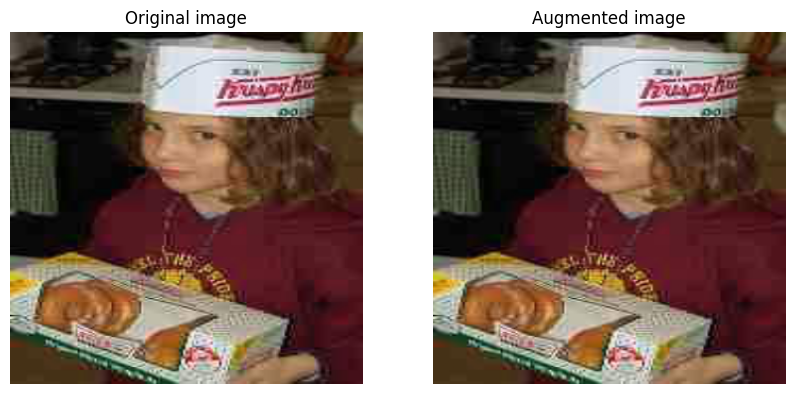

In [45]:
plot_loder(test_loader)

In [46]:
print_shape(train_loader)
print_shape(val_loader)
print_shape(test_loader)

View1 is with shape: torch.Size([512, 3, 332, 332]), the type is torch.float32.
View2 is with shape: torch.Size([512, 3, 332, 332]), the type is torch.float32.
Label is with shape: torch.Size([512, 1, 18]), the type is torch.float32.
View1 is with shape: torch.Size([512, 3, 332, 332]), the type is torch.float32.
View2 is with shape: torch.Size([512, 3, 332, 332]), the type is torch.float32.
Label is with shape: torch.Size([512, 1, 18]), the type is torch.float32.
View1 is with shape: torch.Size([512, 3, 332, 332]), the type is torch.float32.
View2 is with shape: torch.Size([512, 3, 332, 332]), the type is torch.float32.
Label is with shape: torch.Size([512]), the type is torch.float64.


# CLIP features

In [ ]:
model, preprocess = clip.load('ViT-B/32', "cuda")

## Feature fusions

In [ ]:
import torch.nn as nn

class FEATURE_DECISION_DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 18)
        self.dropout = nn.Dropout(p = 0.5)

    def forward(self, inputs):
        inputs = inputs.view(inputs.size(0), -1)  # 添加此行以调整输入张量的形状
        tensor = F.gelu(self.fc1(inputs))
        tensor = self.dropout(tensor)
        tensor = F.gelu(self.fc2(tensor))
        tensor = self.dropout(tensor)
        tensor = torch.sigmoid(self.fc3(tensor))
        return tensor

class DECISION_DECISION_DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(18, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 18)

    def forward(self, inputs):
        tensor = F.gelu(self.fc1(inputs))
        tensor = F.gelu(self.fc2(tensor))
        tensor = torch.sigmoid(self.fc3(tensor))
        return tensor

In [ ]:
pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from torchmetrics import F1Score
from torch import optim

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
def Trainer(net, epoch, epoch_step_1, epoch_step_2):
    model, preprocess = clip.load('ViT-B/32', "cuda")
  
    train_loader, val_loader, _ = get_loader(bs = 600, load_clip = True)
    print_clip_feature(train_loader) 
    #print_clip_feature(train_loader)
    dev = "cuda" if torch.cuda.is_available() else "cpu"
    Net = net.to(dev)
    opti = optim.Adam(Net.parameters(), lr = 1e-3)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(opti, milestones=[epoch_step_1,epoch_step_2], gamma = 0.1)
    f1 = F1Score(task="multilabel", num_labels = 18).to(dev)

    epoch = epoch
    loss_list = []
    f1_list = []

    for epoch in tqdm(range(epoch), colour = 'GREEN'):
        data, view2, cap, label = next(iter(train_loader))  
        data, _, _ = clip_feature(data, view2, cap, model = model, preprocess = preprocess)

        label.to(dev)
        label = label.squeeze(1)  # 添加此行以调整目标张量的形状
        preds = Net(data)        
        loss = F.binary_cross_entropy(preds, label)
        loss.backward()
        opti.step()
        scheduler.step()
        opti.zero_grad()
        loss_list.append(loss)

        Net.eval()
        with torch.autograd.no_grad():
            data_val, _, _, label_val = next(iter(val_loader))
            data_val, label_val = data_val.to(dev), label_val.to(dev)
            label_val = label.squeeze(1)  # 添加此行以调整目标张量的形状
            predict = Net(data_val)
            f1_score = f1(predict, label_val)
            print('F1 in epoch{} : {:.4f}'.format(epoch, f1_score))
        f1_list.append(f1_score)
    
    return Net, loss_list, f1_list

def clip_feature(view1, view2, caption, model, preprocess):
      # view1_input = preprocess(view1).unsqueeze(0)
      # view2_input = preprocess(view2).unsqueeze(0)
      # text_inputs = torch.cat([clip.tokenize(f"{caption}")])
      with torch.no_grad():
        view1_features = model.encode_image(view1.to(dev))
        view2_features = model.encode_image(view2.to(dev))
        # text_features = model.encode_text(text_inputs)

      return view1_features.float(), view2_features.float(), text_features.float()

In [ ]:
from torchvision import transforms

def Trainer(net, epoch, epoch_step_1, epoch_step_2):
    model, preprocess = clip.load('ViT-B/32', "cuda")
  
    dev = "cuda" if torch.cuda.is_available() else "cpu"
    Net = net.to(dev)
    opti = optim.Adam(Net.parameters(), lr = 1e-3)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(opti, milestones=[epoch_step_1,epoch_step_2], gamma = 0.1)
    f1 = F1Score(task="multilabel", num_labels = 18).to(dev)

    epoch = epoch
    loss_list = []
    f1_list = []

    for epoch in tqdm(range(epoch), colour = 'GREEN'):
        train_loader, val_loader, _ = get_loader(bs = 600, load_clip = True)
        for data, view2, cap, label in train_loader:
            data, _, _ = clip_feature(data, view2, cap, model = model, preprocess = preprocess)
            label = label.to(dev)
            label = label.squeeze(1)  # 添加此行以调整目标张量的形状
            preds = Net(data)        
            loss = F.binary_cross_entropy(preds, label)
            loss.backward()
            opti.step()
            scheduler.step()
            opti.zero_grad()
            loss_list.append(loss)

        Net.eval()
        with torch.autograd.no_grad():
            for data_val, _, _, label_val in val_loader:
                data_val, _, _ = clip_feature(data_val, view2, cap, model = model, preprocess = preprocess)
                data_val, label_val = data_val.to(dev), label_val.to(dev)
                label_val = label_val.squeeze(1)  # 添加此行以调整目标张量的形状
                predict = Net(data_val)
                f1_score = f1(predict, label_val)
            print('F1 in epoch{} : {:.4f}'.format(epoch, f1_score))
            f1_list.append(f1_score)
    
    return Net, loss_list, f1_list

def clip_feature(view1, view2, caption, model, preprocess):
    with torch.no_grad():
        view1 = [transforms.ToPILImage()(img) for img in view1]  # 新增此行将张量转换为PIL图像
        view2 = [transforms.ToPILImage()(img) for img in view2]  # 新增此行将张量转换为PIL图像
        view1_features = model.encode_image(torch.stack([preprocess(img) for img in view1]).to(dev))  # 修改此行以适应批量数据
        view2_features = model.encode_image(torch.stack([preprocess(img) for img in view2]).to(dev))  # 修改此行以适应批量数据
        text_features = model.encode_text(clip.tokenize(caption).to(dev))  # 修改此行以适应批量数据

    return view1_features.float(), view2_features.float(), text_features.float()


    return view1_features.float(), view2_features.float(), text_features.float()


In [ ]:
def Trainer(net, epoch, epoch_step_1, epoch_step_2):
    model, preprocess = clip.load('ViT-B/32', "cuda")
  
    dev = "cuda" if torch.cuda.is_available() else "cpu"
    Net = net.to(dev)
    opti = optim.Adam(Net.parameters(), lr = 1e-3)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(opti, milestones=[epoch_step_1,epoch_step_2], gamma = 0.1)
    f1 = F1Score(task="multilabel", num_labels = 18).to(dev)

    epoch = epoch
    loss_list = []
    f1_list = []

    for epoch in tqdm(range(epoch), colour = 'GREEN'):
        train_loader, val_loader, _ = get_loader(bs = 2, load_clip = True)
        for data, view2, cap, label in train_loader:
            data, _, _ = clip_feature(data, view2, cap, model = model, preprocess = preprocess)
            label = label.to(dev)
            label = label.squeeze(1)  # 添加此行以调整目标张量的形状
            preds = Net(data)        
            loss = F.binary_cross_entropy(preds, label)
            loss.backward()
            opti.step()
            scheduler.step()
            opti.zero_grad()
            loss_list.append(loss)

        Net.eval()
        with torch.autograd.no_grad():
            for data_val, _, _, label_val in val_loader:
                data_val, _, _ = clip_feature(data_val, view2, cap, model = model, preprocess = preprocess)
                data_val, label_val = data_val.to(dev), label_val.to(dev)
                label_val = label_val.squeeze(1)  # 添加此行以调整目标张量的形状
                predict = Net(data_val)
                f1_score = f1(predict, label_val)
            print('F1 in epoch{} : {:.4f}'.format(epoch, f1_score))
            f1_list.append(f1_score)
    
    return Net, loss_list, f1_list

def clip_feature(view1, view2, caption, model, preprocess):
    with torch.no_grad():
        view1 = [transforms.ToPILImage()(img) for img in view1]  # 新增此行将张量转换为PIL图像
        view2 = [transforms.ToPILImage()(img) for img in view2]  # 新增此行将张量转换为PIL图像
        view1_features = model.encode_image(torch.stack([preprocess(img) for img in view1]).to(dev))  # 修改此行以适应批量数据
        view2_features = model.encode_image(torch.stack([preprocess(img) for img in view2]).to(dev))  # 修改此行以适应批量数据
        text_features = model.encode_text(clip.tokenize(caption).to(dev))  # 修改此行以适应批量数据

    return view1_features.float(), view2_features.float(), text_features.float()


In [ ]:
dev = "cuda" if torch.cuda.is_available() else "cpu"

Net, loss_list, f1_list = Trainer(FEATURE_DECISION_DNN(), 480, 380, 480)
Net.eval()
# with torch.autograd.no_grad():
#     img_train = Net(all_image_features.to(dev))
#     img_test = Net(test_image_features.to(dev))

  0%|          | 0/480 [00:00<?, ?it/s]

In [ ]:
Net, loss_list, f1_list = Trainer(FEATURE_DECISION_DNN(), 360, 360, 360, all_text_feature)
Net.eval()
with torch.autograd.no_grad():
    txt_train = Net(all_text_feature.to(dev))
    txt_test = Net(test_text_feature.to(dev))

In [ ]:
sum_train = img_train+txt_train
sum_test = img_test+txt_test
Net, loss_list, f1_list = Trainer(DECISION_DECISION_DNN(),300, 220, 270, sum_train)
Net.eval()
with torch.autograd.no_grad():
    final = Net(sum_test)

  0%|          | 1/300 [00:00<02:26,  2.04it/s]

F1 in epoch0 : 0.5577


  1%|          | 2/300 [00:00<01:40,  2.97it/s]

F1 in epoch1 : 0.6004


  1%|          | 3/300 [00:01<02:05,  2.37it/s]

F1 in epoch2 : 0.5941


  1%|▏         | 4/300 [00:01<01:42,  2.88it/s]

F1 in epoch3 : 0.5887


  2%|▏         | 5/300 [00:01<01:59,  2.47it/s]

F1 in epoch4 : 0.5845


  2%|▏         | 6/300 [00:02<02:09,  2.27it/s]

F1 in epoch5 : 0.5834


  2%|▏         | 7/300 [00:02<01:49,  2.67it/s]

F1 in epoch6 : 0.5782


  3%|▎         | 8/300 [00:03<02:01,  2.40it/s]

F1 in epoch7 : 0.5778


  3%|▎         | 9/300 [00:03<01:45,  2.77it/s]

F1 in epoch8 : 0.5778


  3%|▎         | 10/300 [00:03<01:57,  2.47it/s]

F1 in epoch9 : 0.5778


  4%|▎         | 11/300 [00:04<02:09,  2.24it/s]

F1 in epoch10 : 0.5778


  4%|▍         | 12/300 [00:04<01:50,  2.60it/s]

F1 in epoch11 : 0.5778


  4%|▍         | 13/300 [00:05<02:00,  2.38it/s]

F1 in epoch12 : 0.5778


  5%|▍         | 14/300 [00:05<01:44,  2.75it/s]

F1 in epoch13 : 0.5778


  5%|▌         | 15/300 [00:06<01:55,  2.46it/s]

F1 in epoch14 : 0.5778


  5%|▌         | 16/300 [00:06<02:05,  2.27it/s]

F1 in epoch15 : 0.5778


  6%|▌         | 17/300 [00:06<01:47,  2.64it/s]

F1 in epoch16 : 0.5778


  6%|▌         | 18/300 [00:07<01:58,  2.38it/s]

F1 in epoch17 : 0.5778


  6%|▋         | 19/300 [00:07<01:42,  2.74it/s]

F1 in epoch18 : 0.5778


  7%|▋         | 20/300 [00:08<01:54,  2.46it/s]

F1 in epoch19 : 0.5808


  7%|▋         | 21/300 [00:08<01:39,  2.81it/s]

F1 in epoch20 : 0.5860


  7%|▋         | 22/300 [00:08<01:50,  2.51it/s]

F1 in epoch21 : 0.5949


  8%|▊         | 23/300 [00:08<01:36,  2.87it/s]

F1 in epoch22 : 0.6043


  8%|▊         | 24/300 [00:09<01:47,  2.57it/s]

F1 in epoch23 : 0.6175


  8%|▊         | 25/300 [00:09<01:56,  2.35it/s]

F1 in epoch24 : 0.6254


  9%|▊         | 26/300 [00:10<01:40,  2.72it/s]

F1 in epoch25 : 0.6311


  9%|▉         | 27/300 [00:10<01:51,  2.45it/s]

F1 in epoch26 : 0.6319


  9%|▉         | 28/300 [00:10<01:36,  2.82it/s]

F1 in epoch27 : 0.6309


 10%|▉         | 29/300 [00:11<01:48,  2.51it/s]

F1 in epoch28 : 0.6285


 10%|█         | 30/300 [00:11<01:34,  2.85it/s]

F1 in epoch29 : 0.6294


 10%|█         | 31/300 [00:12<01:46,  2.53it/s]

F1 in epoch30 : 0.6257


 11%|█         | 32/300 [00:12<01:55,  2.32it/s]

F1 in epoch31 : 0.6263


 11%|█         | 33/300 [00:12<01:39,  2.67it/s]

F1 in epoch32 : 0.6304


 11%|█▏        | 34/300 [00:13<01:51,  2.38it/s]

F1 in epoch33 : 0.6319


 12%|█▏        | 35/300 [00:13<01:37,  2.72it/s]

F1 in epoch34 : 0.6337


 12%|█▏        | 36/300 [00:14<01:48,  2.42it/s]

F1 in epoch35 : 0.6376


 12%|█▏        | 37/300 [00:14<01:35,  2.76it/s]

F1 in epoch36 : 0.6460


 13%|█▎        | 38/300 [00:14<01:46,  2.46it/s]

F1 in epoch37 : 0.6506


 13%|█▎        | 39/300 [00:15<01:56,  2.23it/s]

F1 in epoch38 : 0.6605


 13%|█▎        | 40/300 [00:15<01:42,  2.54it/s]

F1 in epoch39 : 0.6649


 14%|█▎        | 41/300 [00:16<01:51,  2.32it/s]

F1 in epoch40 : 0.6724


 14%|█▍        | 42/300 [00:16<01:36,  2.69it/s]

F1 in epoch41 : 0.6810


 14%|█▍        | 43/300 [00:17<01:45,  2.43it/s]

F1 in epoch42 : 0.6853


 15%|█▍        | 44/300 [00:17<01:32,  2.77it/s]

F1 in epoch43 : 0.6917


 15%|█▌        | 45/300 [00:17<01:43,  2.47it/s]

F1 in epoch44 : 0.6971


 15%|█▌        | 46/300 [00:18<01:51,  2.28it/s]

F1 in epoch45 : 0.6962


 16%|█▌        | 47/300 [00:18<01:35,  2.64it/s]

F1 in epoch46 : 0.6978


 16%|█▌        | 48/300 [00:19<01:45,  2.39it/s]

F1 in epoch47 : 0.7033


 16%|█▋        | 49/300 [00:19<01:31,  2.74it/s]

F1 in epoch48 : 0.7089


 17%|█▋        | 50/300 [00:19<01:42,  2.43it/s]

F1 in epoch49 : 0.7109


 17%|█▋        | 51/300 [00:20<01:29,  2.78it/s]

F1 in epoch50 : 0.7163


 17%|█▋        | 52/300 [00:20<01:39,  2.49it/s]

F1 in epoch51 : 0.7226


 18%|█▊        | 53/300 [00:21<01:47,  2.30it/s]

F1 in epoch52 : 0.7233


 18%|█▊        | 54/300 [00:21<01:32,  2.67it/s]

F1 in epoch53 : 0.7276


 18%|█▊        | 55/300 [00:21<01:41,  2.41it/s]

F1 in epoch54 : 0.7339


 19%|█▊        | 56/300 [00:22<01:28,  2.76it/s]

F1 in epoch55 : 0.7406


 19%|█▉        | 57/300 [00:22<01:37,  2.48it/s]

F1 in epoch56 : 0.7505


 19%|█▉        | 58/300 [00:22<01:25,  2.85it/s]

F1 in epoch57 : 0.7592


 20%|█▉        | 59/300 [00:23<01:34,  2.55it/s]

F1 in epoch58 : 0.7676


 20%|██        | 60/300 [00:23<01:42,  2.35it/s]

F1 in epoch59 : 0.7710


 20%|██        | 61/300 [00:24<01:28,  2.69it/s]

F1 in epoch60 : 0.7722


 21%|██        | 62/300 [00:24<01:37,  2.44it/s]

F1 in epoch61 : 0.7773


 21%|██        | 63/300 [00:24<01:24,  2.81it/s]

F1 in epoch62 : 0.7803


 21%|██▏       | 64/300 [00:25<01:33,  2.52it/s]

F1 in epoch63 : 0.7842


 22%|██▏       | 65/300 [00:25<01:41,  2.31it/s]

F1 in epoch64 : 0.7896


 22%|██▏       | 66/300 [00:26<01:28,  2.65it/s]

F1 in epoch65 : 0.7927


 22%|██▏       | 67/300 [00:26<01:37,  2.39it/s]

F1 in epoch66 : 0.7946


 23%|██▎       | 68/300 [00:26<01:24,  2.76it/s]

F1 in epoch67 : 0.7972


 23%|██▎       | 69/300 [00:27<01:34,  2.44it/s]

F1 in epoch68 : 0.7993


 23%|██▎       | 70/300 [00:27<01:22,  2.80it/s]

F1 in epoch69 : 0.8009


 24%|██▎       | 71/300 [00:28<01:31,  2.50it/s]

F1 in epoch70 : 0.8012


 24%|██▍       | 72/300 [00:28<01:20,  2.85it/s]

F1 in epoch71 : 0.8042


 24%|██▍       | 73/300 [00:28<01:28,  2.56it/s]

F1 in epoch72 : 0.8095


 25%|██▍       | 74/300 [00:29<01:35,  2.36it/s]

F1 in epoch73 : 0.8127


 25%|██▌       | 75/300 [00:29<01:22,  2.73it/s]

F1 in epoch74 : 0.8152


 25%|██▌       | 76/300 [00:29<01:31,  2.46it/s]

F1 in epoch75 : 0.8193


 26%|██▌       | 77/300 [00:30<01:19,  2.82it/s]

F1 in epoch76 : 0.8204


 26%|██▌       | 78/300 [00:30<01:27,  2.52it/s]

F1 in epoch77 : 0.8222


 26%|██▋       | 79/300 [00:30<01:16,  2.88it/s]

F1 in epoch78 : 0.8231


 27%|██▋       | 80/300 [00:31<01:25,  2.57it/s]

F1 in epoch79 : 0.8261


 27%|██▋       | 81/300 [00:31<01:33,  2.33it/s]

F1 in epoch80 : 0.8268


 27%|██▋       | 82/300 [00:32<01:21,  2.69it/s]

F1 in epoch81 : 0.8279


 28%|██▊       | 83/300 [00:32<01:29,  2.44it/s]

F1 in epoch82 : 0.8268


 28%|██▊       | 84/300 [00:32<01:17,  2.79it/s]

F1 in epoch83 : 0.8270


 28%|██▊       | 85/300 [00:33<01:25,  2.52it/s]

F1 in epoch84 : 0.8270


 29%|██▊       | 86/300 [00:33<01:31,  2.33it/s]

F1 in epoch85 : 0.8265


 29%|██▉       | 87/300 [00:34<01:19,  2.70it/s]

F1 in epoch86 : 0.8305


 29%|██▉       | 88/300 [00:34<01:27,  2.42it/s]

F1 in epoch87 : 0.8312


 30%|██▉       | 89/300 [00:34<01:17,  2.73it/s]

F1 in epoch88 : 0.8307


 30%|███       | 90/300 [00:35<01:26,  2.44it/s]

F1 in epoch89 : 0.8322


 30%|███       | 91/300 [00:35<01:14,  2.79it/s]

F1 in epoch90 : 0.8332


 31%|███       | 92/300 [00:36<01:22,  2.52it/s]

F1 in epoch91 : 0.8346


 31%|███       | 93/300 [00:36<01:28,  2.33it/s]

F1 in epoch92 : 0.8352


 31%|███▏      | 94/300 [00:36<01:16,  2.70it/s]

F1 in epoch93 : 0.8367


 32%|███▏      | 95/300 [00:37<01:23,  2.45it/s]

F1 in epoch94 : 0.8374


 32%|███▏      | 96/300 [00:37<01:12,  2.80it/s]

F1 in epoch95 : 0.8398


 32%|███▏      | 97/300 [00:38<01:21,  2.50it/s]

F1 in epoch96 : 0.8391


 33%|███▎      | 98/300 [00:38<01:10,  2.85it/s]

F1 in epoch97 : 0.8414


 33%|███▎      | 99/300 [00:38<01:19,  2.54it/s]

F1 in epoch98 : 0.8427


 33%|███▎      | 100/300 [00:39<01:26,  2.32it/s]

F1 in epoch99 : 0.8438


 34%|███▎      | 101/300 [00:39<01:14,  2.68it/s]

F1 in epoch100 : 0.8438


 34%|███▍      | 102/300 [00:40<01:21,  2.43it/s]

F1 in epoch101 : 0.8435


 34%|███▍      | 103/300 [00:40<01:11,  2.76it/s]

F1 in epoch102 : 0.8440


 35%|███▍      | 104/300 [00:40<01:18,  2.48it/s]

F1 in epoch103 : 0.8458


 35%|███▌      | 105/300 [00:41<01:24,  2.29it/s]

F1 in epoch104 : 0.8462


 35%|███▌      | 106/300 [00:41<01:13,  2.65it/s]

F1 in epoch105 : 0.8458


 36%|███▌      | 107/300 [00:42<01:20,  2.41it/s]

F1 in epoch106 : 0.8467


 36%|███▌      | 108/300 [00:42<01:09,  2.77it/s]

F1 in epoch107 : 0.8462


 36%|███▋      | 109/300 [00:42<01:16,  2.49it/s]

F1 in epoch108 : 0.8469


 37%|███▋      | 110/300 [00:43<01:22,  2.29it/s]

F1 in epoch109 : 0.8487


 37%|███▋      | 111/300 [00:43<01:11,  2.66it/s]

F1 in epoch110 : 0.8487


 37%|███▋      | 112/300 [00:44<01:18,  2.40it/s]

F1 in epoch111 : 0.8508


 38%|███▊      | 113/300 [00:44<01:07,  2.77it/s]

F1 in epoch112 : 0.8514


 38%|███▊      | 114/300 [00:44<01:15,  2.48it/s]

F1 in epoch113 : 0.8520


 38%|███▊      | 115/300 [00:45<01:05,  2.83it/s]

F1 in epoch114 : 0.8520


 39%|███▊      | 116/300 [00:45<01:13,  2.51it/s]

F1 in epoch115 : 0.8514


 39%|███▉      | 117/300 [00:45<01:04,  2.85it/s]

F1 in epoch116 : 0.8520


 39%|███▉      | 118/300 [00:46<01:11,  2.54it/s]

F1 in epoch117 : 0.8528


 40%|███▉      | 119/300 [00:46<01:17,  2.33it/s]

F1 in epoch118 : 0.8535


 40%|████      | 120/300 [00:47<01:06,  2.70it/s]

F1 in epoch119 : 0.8540


 40%|████      | 121/300 [00:47<01:13,  2.43it/s]

F1 in epoch120 : 0.8527


 41%|████      | 122/300 [00:47<01:03,  2.78it/s]

F1 in epoch121 : 0.8520


 41%|████      | 123/300 [00:48<01:11,  2.49it/s]

F1 in epoch122 : 0.8520


 41%|████▏     | 124/300 [00:48<01:02,  2.80it/s]

F1 in epoch123 : 0.8520


 42%|████▏     | 125/300 [00:49<01:09,  2.51it/s]

F1 in epoch124 : 0.8520


 42%|████▏     | 126/300 [00:49<01:14,  2.33it/s]

F1 in epoch125 : 0.8527


 42%|████▏     | 127/300 [00:49<01:04,  2.70it/s]

F1 in epoch126 : 0.8527


 43%|████▎     | 128/300 [00:50<01:10,  2.44it/s]

F1 in epoch127 : 0.8533


 43%|████▎     | 129/300 [00:50<01:01,  2.76it/s]

F1 in epoch128 : 0.8533


 43%|████▎     | 130/300 [00:51<01:10,  2.41it/s]

F1 in epoch129 : 0.8540


 44%|████▎     | 131/300 [00:51<01:03,  2.66it/s]

F1 in epoch130 : 0.8540


 44%|████▍     | 132/300 [00:51<01:10,  2.37it/s]

F1 in epoch131 : 0.8540


 44%|████▍     | 133/300 [00:52<01:18,  2.11it/s]

F1 in epoch132 : 0.8538


 45%|████▍     | 134/300 [00:52<01:07,  2.46it/s]

F1 in epoch133 : 0.8538


 45%|████▌     | 135/300 [00:53<01:15,  2.20it/s]

F1 in epoch134 : 0.8555


 45%|████▌     | 136/300 [00:53<01:03,  2.57it/s]

F1 in epoch135 : 0.8555


 46%|████▌     | 137/300 [00:54<01:09,  2.36it/s]

F1 in epoch136 : 0.8562


 46%|████▌     | 138/300 [00:54<00:59,  2.72it/s]

F1 in epoch137 : 0.8562


 46%|████▋     | 139/300 [00:54<01:05,  2.47it/s]

F1 in epoch138 : 0.8568


 47%|████▋     | 140/300 [00:55<01:09,  2.30it/s]

F1 in epoch139 : 0.8573


 47%|████▋     | 141/300 [00:55<00:59,  2.68it/s]

F1 in epoch140 : 0.8573


 47%|████▋     | 142/300 [00:56<01:05,  2.43it/s]

F1 in epoch141 : 0.8573


 48%|████▊     | 143/300 [00:56<00:56,  2.79it/s]

F1 in epoch142 : 0.8573


 48%|████▊     | 144/300 [00:56<01:02,  2.48it/s]

F1 in epoch143 : 0.8579


 48%|████▊     | 145/300 [00:56<00:54,  2.83it/s]

F1 in epoch144 : 0.8584


 49%|████▊     | 146/300 [00:57<01:01,  2.52it/s]

F1 in epoch145 : 0.8591


 49%|████▉     | 147/300 [00:57<01:05,  2.32it/s]

F1 in epoch146 : 0.8591


 49%|████▉     | 148/300 [00:58<00:56,  2.68it/s]

F1 in epoch147 : 0.8591


 50%|████▉     | 149/300 [00:58<01:02,  2.42it/s]

F1 in epoch148 : 0.8592


 50%|█████     | 150/300 [00:58<00:54,  2.75it/s]

F1 in epoch149 : 0.8592


 50%|█████     | 151/300 [00:59<01:00,  2.47it/s]

F1 in epoch150 : 0.8592


 51%|█████     | 152/300 [00:59<00:52,  2.81it/s]

F1 in epoch151 : 0.8592


 51%|█████     | 153/300 [01:00<00:58,  2.53it/s]

F1 in epoch152 : 0.8598


 51%|█████▏    | 154/300 [01:00<01:03,  2.32it/s]

F1 in epoch153 : 0.8598


 52%|█████▏    | 155/300 [01:00<00:54,  2.68it/s]

F1 in epoch154 : 0.8600


 52%|█████▏    | 156/300 [01:01<00:59,  2.44it/s]

F1 in epoch155 : 0.8600


 52%|█████▏    | 157/300 [01:01<00:51,  2.76it/s]

F1 in epoch156 : 0.8595


 53%|█████▎    | 158/300 [01:02<00:57,  2.48it/s]

F1 in epoch157 : 0.8590


 53%|█████▎    | 159/300 [01:02<01:01,  2.29it/s]

F1 in epoch158 : 0.8590


 53%|█████▎    | 160/300 [01:02<00:53,  2.63it/s]

F1 in epoch159 : 0.8597


 54%|█████▎    | 161/300 [01:03<00:58,  2.38it/s]

F1 in epoch160 : 0.8597


 54%|█████▍    | 162/300 [01:03<00:50,  2.74it/s]

F1 in epoch161 : 0.8597


 54%|█████▍    | 163/300 [01:04<00:55,  2.45it/s]

F1 in epoch162 : 0.8592


 55%|█████▍    | 164/300 [01:04<00:49,  2.77it/s]

F1 in epoch163 : 0.8598


 55%|█████▌    | 165/300 [01:05<00:55,  2.45it/s]

F1 in epoch164 : 0.8598


 55%|█████▌    | 166/300 [01:05<00:48,  2.74it/s]

F1 in epoch165 : 0.8598


 56%|█████▌    | 167/300 [01:05<00:53,  2.47it/s]

F1 in epoch166 : 0.8598


 56%|█████▌    | 168/300 [01:06<00:57,  2.29it/s]

F1 in epoch167 : 0.8594


 56%|█████▋    | 169/300 [01:06<00:50,  2.62it/s]

F1 in epoch168 : 0.8587


 57%|█████▋    | 170/300 [01:07<00:54,  2.38it/s]

F1 in epoch169 : 0.8583


 57%|█████▋    | 171/300 [01:07<00:47,  2.73it/s]

F1 in epoch170 : 0.8583


 57%|█████▋    | 172/300 [01:07<00:52,  2.43it/s]

F1 in epoch171 : 0.8583


 58%|█████▊    | 173/300 [01:08<00:45,  2.79it/s]

F1 in epoch172 : 0.8583


 58%|█████▊    | 174/300 [01:08<00:50,  2.51it/s]

F1 in epoch173 : 0.8578


 58%|█████▊    | 175/300 [01:09<00:53,  2.32it/s]

F1 in epoch174 : 0.8573


 59%|█████▊    | 176/300 [01:09<00:46,  2.68it/s]

F1 in epoch175 : 0.8579


 59%|█████▉    | 177/300 [01:09<00:50,  2.44it/s]

F1 in epoch176 : 0.8592


 59%|█████▉    | 178/300 [01:09<00:43,  2.80it/s]

F1 in epoch177 : 0.8592


 60%|█████▉    | 179/300 [01:10<00:48,  2.51it/s]

F1 in epoch178 : 0.8592


 60%|██████    | 180/300 [01:11<00:51,  2.31it/s]

F1 in epoch179 : 0.8600


 60%|██████    | 181/300 [01:11<00:44,  2.68it/s]

F1 in epoch180 : 0.8600


 61%|██████    | 182/300 [01:11<00:48,  2.43it/s]

F1 in epoch181 : 0.8600


 61%|██████    | 183/300 [01:11<00:42,  2.78it/s]

F1 in epoch182 : 0.8590


 61%|██████▏   | 184/300 [01:12<00:46,  2.48it/s]

F1 in epoch183 : 0.8590


 62%|██████▏   | 185/300 [01:12<00:40,  2.83it/s]

F1 in epoch184 : 0.8590


 62%|██████▏   | 186/300 [01:13<00:44,  2.53it/s]

F1 in epoch185 : 0.8590


 62%|██████▏   | 187/300 [01:13<00:48,  2.33it/s]

F1 in epoch186 : 0.8590


 63%|██████▎   | 188/300 [01:13<00:41,  2.69it/s]

F1 in epoch187 : 0.8586


 63%|██████▎   | 189/300 [01:14<00:45,  2.43it/s]

F1 in epoch188 : 0.8586


 63%|██████▎   | 190/300 [01:14<00:39,  2.78it/s]

F1 in epoch189 : 0.8586


 64%|██████▎   | 191/300 [01:15<00:43,  2.49it/s]

F1 in epoch190 : 0.8586


 64%|██████▍   | 192/300 [01:15<00:38,  2.82it/s]

F1 in epoch191 : 0.8586


 64%|██████▍   | 193/300 [01:15<00:42,  2.54it/s]

F1 in epoch192 : 0.8590


 65%|██████▍   | 194/300 [01:16<00:45,  2.34it/s]

F1 in epoch193 : 0.8586


 65%|██████▌   | 195/300 [01:16<00:39,  2.69it/s]

F1 in epoch194 : 0.8586


 65%|██████▌   | 196/300 [01:17<00:43,  2.40it/s]

F1 in epoch195 : 0.8586


 66%|██████▌   | 197/300 [01:17<00:37,  2.74it/s]

F1 in epoch196 : 0.8586


 66%|██████▌   | 198/300 [01:17<00:41,  2.47it/s]

F1 in epoch197 : 0.8592


 66%|██████▋   | 199/300 [01:18<00:43,  2.30it/s]

F1 in epoch198 : 0.8586


 67%|██████▋   | 200/300 [01:18<00:37,  2.65it/s]

F1 in epoch199 : 0.8586


 67%|██████▋   | 201/300 [01:19<00:41,  2.41it/s]

F1 in epoch200 : 0.8586


 67%|██████▋   | 202/300 [01:19<00:35,  2.78it/s]

F1 in epoch201 : 0.8586


 68%|██████▊   | 203/300 [01:19<00:38,  2.51it/s]

F1 in epoch202 : 0.8586


 68%|██████▊   | 204/300 [01:20<00:41,  2.32it/s]

F1 in epoch203 : 0.8586


 68%|██████▊   | 205/300 [01:20<00:35,  2.69it/s]

F1 in epoch204 : 0.8586


 69%|██████▊   | 206/300 [01:21<00:38,  2.43it/s]

F1 in epoch205 : 0.8586


 69%|██████▉   | 207/300 [01:21<00:33,  2.79it/s]

F1 in epoch206 : 0.8586


 69%|██████▉   | 208/300 [01:21<00:37,  2.48it/s]

F1 in epoch207 : 0.8586


 70%|██████▉   | 209/300 [01:22<00:32,  2.84it/s]

F1 in epoch208 : 0.8586


 70%|███████   | 210/300 [01:22<00:35,  2.50it/s]

F1 in epoch209 : 0.8586


 70%|███████   | 211/300 [01:22<00:31,  2.85it/s]

F1 in epoch210 : 0.8581


 71%|███████   | 212/300 [01:23<00:34,  2.55it/s]

F1 in epoch211 : 0.8581


 71%|███████   | 213/300 [01:23<00:37,  2.34it/s]

F1 in epoch212 : 0.8581


 71%|███████▏  | 214/300 [01:24<00:31,  2.71it/s]

F1 in epoch213 : 0.8581


 72%|███████▏  | 215/300 [01:24<00:34,  2.45it/s]

F1 in epoch214 : 0.8581


 72%|███████▏  | 216/300 [01:24<00:29,  2.81it/s]

F1 in epoch215 : 0.8581


 72%|███████▏  | 217/300 [01:25<00:33,  2.50it/s]

F1 in epoch216 : 0.8581


 73%|███████▎  | 218/300 [01:25<00:28,  2.84it/s]

F1 in epoch217 : 0.8587


 73%|███████▎  | 219/300 [01:26<00:32,  2.53it/s]

F1 in epoch218 : 0.8587


 73%|███████▎  | 220/300 [01:26<00:34,  2.32it/s]

F1 in epoch219 : 0.8587


 74%|███████▎  | 221/300 [01:26<00:29,  2.69it/s]

F1 in epoch220 : 0.8582


 74%|███████▍  | 222/300 [01:27<00:32,  2.43it/s]

F1 in epoch221 : 0.8582


 74%|███████▍  | 223/300 [01:27<00:27,  2.76it/s]

F1 in epoch222 : 0.8582


 75%|███████▍  | 224/300 [01:28<00:30,  2.47it/s]

F1 in epoch223 : 0.8582


 75%|███████▌  | 225/300 [01:28<00:26,  2.83it/s]

F1 in epoch224 : 0.8582


 75%|███████▌  | 226/300 [01:28<00:29,  2.52it/s]

F1 in epoch225 : 0.8582


 76%|███████▌  | 227/300 [01:29<00:32,  2.28it/s]

F1 in epoch226 : 0.8582


 76%|███████▌  | 228/300 [01:29<00:27,  2.63it/s]

F1 in epoch227 : 0.8582


 76%|███████▋  | 229/300 [01:30<00:29,  2.37it/s]

F1 in epoch228 : 0.8582


 77%|███████▋  | 230/300 [01:30<00:25,  2.73it/s]

F1 in epoch229 : 0.8582


 77%|███████▋  | 231/300 [01:30<00:28,  2.46it/s]

F1 in epoch230 : 0.8582


 77%|███████▋  | 232/300 [01:31<00:24,  2.81it/s]

F1 in epoch231 : 0.8582


 78%|███████▊  | 233/300 [01:31<00:27,  2.48it/s]

F1 in epoch232 : 0.8582


 78%|███████▊  | 234/300 [01:32<00:28,  2.28it/s]

F1 in epoch233 : 0.8582


 78%|███████▊  | 235/300 [01:32<00:24,  2.65it/s]

F1 in epoch234 : 0.8582


 79%|███████▊  | 236/300 [01:32<00:26,  2.40it/s]

F1 in epoch235 : 0.8582


 79%|███████▉  | 237/300 [01:33<00:22,  2.76it/s]

F1 in epoch236 : 0.8582


 79%|███████▉  | 238/300 [01:33<00:25,  2.47it/s]

F1 in epoch237 : 0.8582


 80%|███████▉  | 239/300 [01:33<00:21,  2.82it/s]

F1 in epoch238 : 0.8582


 80%|████████  | 240/300 [01:34<00:23,  2.52it/s]

F1 in epoch239 : 0.8582


 80%|████████  | 241/300 [01:34<00:25,  2.32it/s]

F1 in epoch240 : 0.8582


 81%|████████  | 242/300 [01:35<00:21,  2.68it/s]

F1 in epoch241 : 0.8582


 81%|████████  | 243/300 [01:35<00:23,  2.38it/s]

F1 in epoch242 : 0.8582


 81%|████████▏ | 244/300 [01:35<00:20,  2.73it/s]

F1 in epoch243 : 0.8582


 82%|████████▏ | 245/300 [01:36<00:22,  2.46it/s]

F1 in epoch244 : 0.8582


 82%|████████▏ | 246/300 [01:36<00:19,  2.82it/s]

F1 in epoch245 : 0.8582


 82%|████████▏ | 247/300 [01:37<00:20,  2.54it/s]

F1 in epoch246 : 0.8582


 83%|████████▎ | 248/300 [01:37<00:22,  2.34it/s]

F1 in epoch247 : 0.8582


 83%|████████▎ | 249/300 [01:37<00:18,  2.71it/s]

F1 in epoch248 : 0.8582


 83%|████████▎ | 250/300 [01:38<00:20,  2.45it/s]

F1 in epoch249 : 0.8587


 84%|████████▎ | 251/300 [01:38<00:17,  2.81it/s]

F1 in epoch250 : 0.8587


 84%|████████▍ | 252/300 [01:39<00:19,  2.52it/s]

F1 in epoch251 : 0.8587


 84%|████████▍ | 253/300 [01:39<00:20,  2.33it/s]

F1 in epoch252 : 0.8587


 85%|████████▍ | 254/300 [01:39<00:17,  2.68it/s]

F1 in epoch253 : 0.8587


 85%|████████▌ | 255/300 [01:40<00:18,  2.41it/s]

F1 in epoch254 : 0.8587


 85%|████████▌ | 256/300 [01:40<00:15,  2.77it/s]

F1 in epoch255 : 0.8587


 86%|████████▌ | 257/300 [01:41<00:17,  2.47it/s]

F1 in epoch256 : 0.8587


 86%|████████▌ | 258/300 [01:41<00:14,  2.81it/s]

F1 in epoch257 : 0.8587


 86%|████████▋ | 259/300 [01:41<00:16,  2.43it/s]

F1 in epoch258 : 0.8587


 87%|████████▋ | 260/300 [01:42<00:14,  2.77it/s]

F1 in epoch259 : 0.8587


 87%|████████▋ | 261/300 [01:42<00:15,  2.48it/s]

F1 in epoch260 : 0.8587


 87%|████████▋ | 262/300 [01:43<00:16,  2.30it/s]

F1 in epoch261 : 0.8587


 88%|████████▊ | 263/300 [01:43<00:13,  2.67it/s]

F1 in epoch262 : 0.8587


 88%|████████▊ | 264/300 [01:43<00:14,  2.42it/s]

F1 in epoch263 : 0.8587


 88%|████████▊ | 265/300 [01:44<00:12,  2.74it/s]

F1 in epoch264 : 0.8587


 89%|████████▊ | 266/300 [01:44<00:13,  2.47it/s]

F1 in epoch265 : 0.8587


 89%|████████▉ | 267/300 [01:44<00:11,  2.82it/s]

F1 in epoch266 : 0.8587


 89%|████████▉ | 268/300 [01:45<00:12,  2.53it/s]

F1 in epoch267 : 0.8587


 90%|████████▉ | 269/300 [01:45<00:13,  2.33it/s]

F1 in epoch268 : 0.8587


 90%|█████████ | 270/300 [01:46<00:11,  2.69it/s]

F1 in epoch269 : 0.8587


 90%|█████████ | 271/300 [01:46<00:11,  2.43it/s]

F1 in epoch270 : 0.8587


 91%|█████████ | 272/300 [01:46<00:10,  2.79it/s]

F1 in epoch271 : 0.8587


 91%|█████████ | 273/300 [01:47<00:10,  2.50it/s]

F1 in epoch272 : 0.8587


 91%|█████████▏| 274/300 [01:47<00:11,  2.28it/s]

F1 in epoch273 : 0.8587


 92%|█████████▏| 275/300 [01:48<00:09,  2.65it/s]

F1 in epoch274 : 0.8587


 92%|█████████▏| 276/300 [01:48<00:10,  2.37it/s]

F1 in epoch275 : 0.8587


 92%|█████████▏| 277/300 [01:48<00:08,  2.71it/s]

F1 in epoch276 : 0.8587


 93%|█████████▎| 278/300 [01:49<00:09,  2.44it/s]

F1 in epoch277 : 0.8587


 93%|█████████▎| 279/300 [01:49<00:07,  2.78it/s]

F1 in epoch278 : 0.8587


 93%|█████████▎| 280/300 [01:50<00:07,  2.50it/s]

F1 in epoch279 : 0.8587


 94%|█████████▎| 281/300 [01:50<00:08,  2.30it/s]

F1 in epoch280 : 0.8587


 94%|█████████▍| 282/300 [01:50<00:06,  2.66it/s]

F1 in epoch281 : 0.8587


 94%|█████████▍| 283/300 [01:51<00:07,  2.42it/s]

F1 in epoch282 : 0.8587


 95%|█████████▍| 284/300 [01:51<00:05,  2.76it/s]

F1 in epoch283 : 0.8587


 95%|█████████▌| 285/300 [01:52<00:06,  2.48it/s]

F1 in epoch284 : 0.8587


 95%|█████████▌| 286/300 [01:52<00:04,  2.82it/s]

F1 in epoch285 : 0.8587


 96%|█████████▌| 287/300 [01:52<00:05,  2.51it/s]

F1 in epoch286 : 0.8587


 96%|█████████▌| 288/300 [01:53<00:05,  2.32it/s]

F1 in epoch287 : 0.8587


 96%|█████████▋| 289/300 [01:53<00:04,  2.67it/s]

F1 in epoch288 : 0.8587


 97%|█████████▋| 290/300 [01:54<00:04,  2.42it/s]

F1 in epoch289 : 0.8587


 97%|█████████▋| 291/300 [01:54<00:03,  2.72it/s]

F1 in epoch290 : 0.8587


 97%|█████████▋| 292/300 [01:54<00:03,  2.45it/s]

F1 in epoch291 : 0.8587


 98%|█████████▊| 293/300 [01:55<00:03,  2.28it/s]

F1 in epoch292 : 0.8587


 98%|█████████▊| 294/300 [01:55<00:02,  2.64it/s]

F1 in epoch293 : 0.8587


 98%|█████████▊| 295/300 [01:56<00:02,  2.42it/s]

F1 in epoch294 : 0.8587


 99%|█████████▊| 296/300 [01:56<00:01,  2.78it/s]

F1 in epoch295 : 0.8587


 99%|█████████▉| 297/300 [01:56<00:01,  2.50it/s]

F1 in epoch296 : 0.8587


 99%|█████████▉| 298/300 [01:57<00:00,  2.31it/s]

F1 in epoch297 : 0.8587


100%|█████████▉| 299/300 [01:57<00:00,  2.68it/s]

F1 in epoch298 : 0.8587


100%|██████████| 300/300 [01:58<00:00,  2.54it/s]

F1 in epoch299 : 0.8587


In [ ]:
y_proba = final.cpu().numpy()

resl = []
for i in y_proba:
  a = [x+1 for x in range(len(i)) if i[x] > 0.5]
  for j in range(len(a)):
    if a[j] >=12:
      a[j] = a[j]+1
  resl.append(a)

test_pred = []
for lis in resl:
  a = [str(i) for i in lis]
  test_pred.append(" ".join(a))

# output_df = pd.DataFrame(test_pred, columns = ['Labels'])

# # The best model of our prediction data on kaggle is svm.
# # Select the prediction of svm model for output.
# output_df = pd.DataFrame(test_pred, columns = ['Labels'])
# output_df.to_csv('/content/Predicted_labels.csv')
# df.to_csv("/content/Predicted_labels.csv".format(str(output_df)), index= False)
# print

# make a csv file
df = pd.DataFrame(columns=["ImageID", "Labels"])
# Creating the Second Dataframe using dictionary
for index, value in enumerate(test_pred):
    df_temp = pd.DataFrame({"ImageID":"{}.jpg".format(30000+index), "Labels":" ".join([str(i) for i in [value]])}, index=[0])
    # for appending df_temp at the end of df
    df = df.append(df_temp, ignore_index = True)

df.to_csv("/content/Predicted_labels.csv", index = False)